In [1]:
#https://github.com/likejazz/jupyter-notebooks/blob/master/deep-learning/addition_rnn.py

# %%
"""
An implementation of sequence to sequence learning for performing addition
<https://github.com/keras-team/keras/blob/master/examples/addition_rnn.py>
Input: "535+61"
Output: "596"
Padding is handled by using a repeated sentinel character (space)
Input may optionally be reversed, shown to increase performance in many tasks in:
"Learning to Execute"
http://arxiv.org/abs/1410.4615
and
"Sequence to Sequence Learning with Neural Networks"
http://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf
Theoretically it introduces shorter term dependencies between source and target.
"""

from __future__ import print_function
from keras.models import Sequential
from keras.layers import LSTM, RepeatVector, Dense, Activation, TimeDistributed
import numpy as np
from six.moves import range


Using TensorFlow backend.


In [0]:
class CharacterTable(object):
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One hot encode given string C.
        # Arguments
            num_rows: Number of rows in the returned one hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)


class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'


# --

In [3]:
# Parameters for the model and dataset.
TRAINING_SIZE = 50000
DIGITS = 3
REVERSE = True

# Maximum length of input is 'int + int' (e.g., '345+678'). Maximum length of int is DIGITS.
MAXLEN = DIGITS + 1 + DIGITS

# All the numbers, plus sign and space for padding.
chars = '0123456789+ '
ctable = CharacterTable(chars)

questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                            for _ in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a + b)
    # Answers can be of maximum size DIGITS + 1.
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        # Reverse the query, e.g., '12+345  ' becomes '  543+21'. (Note the
        # space used for padding.)
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool)

for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

# Shuffle (x, y) in unison as the later parts of x will almost all be larger digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

# --

Generating data...
Total addition questions: 50000
Vectorization...
Training Data:
(45000, 7, 12)
(45000, 4, 12)
Validation Data:
(5000, 7, 12)
(5000, 4, 12)


In [4]:
# %%
BATCH_SIZE = 64

print('Build model...')
model = Sequential()
# "Encode" the input sequence using an RNN.
model.add(LSTM(64, input_shape=(MAXLEN, len(chars))))
# As the decoder RNN's input, repeatedly provide with the last hidden state of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(RepeatVector(DIGITS + 1))
model.add(LSTM(32, return_sequences=True))

model.add(TimeDistributed(Dense(len(chars))))
model.add(Activation('softmax'))
# <https://stackoverflow.com/a/46004661/3513266>
# from keras.metrics import categorical_accuracy
# model.compile(loss='binary_crossentropy',
#               optimizer='adam', metrics=[categorical_accuracy])
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])
model.summary()

Build model...





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                19712     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 32)             12416     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 12)             396       
_________________________________________________________________
activation_1 (Activation)    (None, 4, 12)             0         
Total params: 32,524
Trainable params: 32,524
Non-trainable params: 0
_________________________________________________________________


In [5]:
# %%
model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=50,
          validation_data=(x_val, y_val))

# %%
# Select 10 samples from the validation set at random so we can visualize errors.
for i in range(10):
    ind = np.random.randint(0, len(x_val))
    rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
    preds = model.predict_classes(rowx)
    q = ctable.decode(rowx[0])
    correct = ctable.decode(rowy[0])
    guess = ctable.decode(preds[0], calc_argmax=False)
    print('%5d' % ind, end=': ')
    print('Q', q[::-1] if REVERSE else q, end=' ')
    print('T', correct, end=' ')
    if correct == guess:
        print(colors.ok + '☑' + colors.close, end=' ')
    else:
        print(colors.fail + '☒' + colors.close, end=' ')
    print(guess)

# %% Print final results.
i = 2975
output_final = model.predict(np.array([x_val[i]]))

print(ctable.decode(x_val[i]),
      ctable.decode(y_val[i]),
      ctable.decode(output_final[0]))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 45000 samples, validate on 5000 samples
Epoch 1/50





45000/45000 [==============================] - 30s 670us/step - loss: 1.8885 - acc: 0.3227 - val_loss: 1.8009 - val_acc: 0.3474
Epoch 2/50
45000/45000 [==============================] - 24s 540us/step - loss: 1.7598 - acc: 0.3522 - val_loss: 1.7255 - val_acc: 0.3633
Epoch 3/50
45000/45000 [==============================] - 24s 540us/step - loss: 1.6749 - acc: 0.3778 - val_loss: 1.6308 - val_acc: 0.4017
Epoch 4/50
45000/45000 [==============================] - 24s 534us/step - loss: 1.5542 - acc: 0.4266 - val_loss: 1.4756 - val_acc: 0.4667
Epoch 5/50
45000/45000 [==============================] - 25s 547us/step - loss: 1.4254 - acc: 0.4780 - val_loss: 1.3738 - val_acc: 0.4951
Epoch 6/50
45000/45000 [==============================] - 24s 540us/step - loss: 1.3314 - acc: 0.5122 - val_loss: 1.3000 - val_acc: 0.5276
Epoch 7/50
4500

(1, 4, 12)


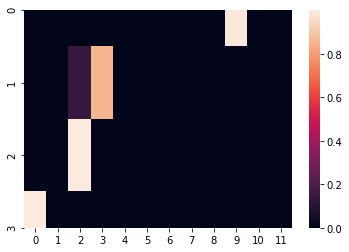

lstm_1/kernel:0 (12, 256)
[[-0.34842145 -0.6015014  -0.28206107 ... -1.4924046  -0.26111946
  -0.49554265]
 [ 0.24461417 -0.6161232  -0.13870609 ... -1.371071    1.3007562
   0.36224097]
 [-1.3327584   0.6924768   0.00528515 ... -0.40645933  0.21285152
  -1.0268382 ]
 ...
 [-0.17469373  0.39099395 -0.18956205 ...  0.61584127 -0.60158926
  -0.1220063 ]
 [ 0.21798176  0.5702935   0.06164977 ...  0.3464856  -0.6345232
  -0.71967953]
 [-0.26164317  0.73763293  0.5375261  ... -0.20976159 -0.38023445
  -0.6704178 ]]
lstm_1/recurrent_kernel:0 (64, 256)
[[-0.07259123  0.01725388 -0.15761138 ... -0.9583497  -0.16796358
  -0.27304217]
 [ 0.49339336  0.2136172  -0.0417339  ... -0.13079697  0.6654904
   0.07428343]
 [ 0.49809474  0.39910772  0.58097243 ... -0.05935094  0.03431176
   0.20428336]
 ...
 [-0.19726746  0.03590891  0.223036   ... -0.6504134   0.06130451
  -0.03242338]
 [ 0.5032811   0.32537842  0.614183   ...  0.40874565 -0.06267741
   0.06588752]
 [-0.414325   -0.19861636 -0.14891197 .

In [6]:
# %%
from keras.models import Model

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[4].output)
output = intermediate_layer_model.predict(np.array([x_val[i]]))
print(output.shape)

import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()
# h = np.reshape(output[0], (-1, 8))
# sns.heatmap(h)
sns.heatmap(output[0])
plt.show()

# %% Print weights.
names = [weight.name for layer in model.layers for weight in layer.weights]
weights = model.get_weights()

# suppress scientific notation
np.set_printoptions(suppress=True)
for name, weight in zip(names, weights):
    print(name, weight.shape)
    print(weight)